# Forecast skill

Showcasing model evaluation for forecasting when using modelskill

In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import modelskill as ms

In [246]:
sns.set_palette("Set1")

In this notebook, we depart from a dataframe containing matched results from two models. To see how that dataframe is created, consider visiting the [data wrangling notebook](../notebooks/Forecast_data_wrangling.ipynb).


In [247]:
def path_to_file(filename):
    return f"../tests/testdata/forecast_skill/{filename}"

matched_model_results = pd.read_csv(path_to_file("matched_model_results.csv"), parse_dates=True, index_col=0)
matched_model_results.round(2).head()

,lead_time,model_1,model_2,observation
date,,,,
2023-01-07,1,13804.10,12663.04,14319.96
2023-01-07,2,13302.96,12898.16,14319.96
2023-01-07,3,13388.44,13505.24,14319.96
2023-01-07,4,13014.56,13444.72,14319.96
2023-01-07,5,12845.50,13086.09,14319.96


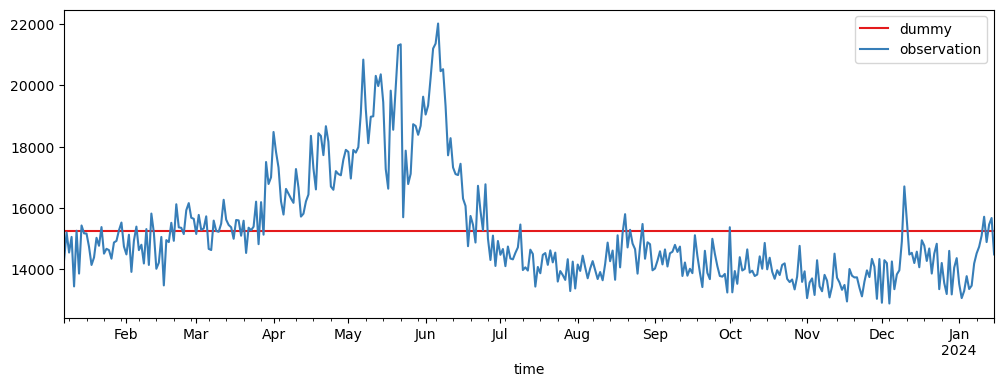

In [248]:
observations = matched_model_results["observation"].drop_duplicates().to_frame()

obs = ms.PointObservation(observations)
mr = ms.DummyModelResult(strategy='mean')
pmr = mr.extract(obs).to_dataframe()

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
pmr.merge(observations, on="time").plot(ax=ax)
plt.show()


In [249]:
pmr.index.name = "date"
matched_model_results = matched_model_results.merge(pmr, on="date", how="inner")
cmp = ms.from_matched(matched_model_results, mod_items=["model_1", "model_2", "dummy"], aux_items=["lead_time"], obs_item="observation")

metrics = ["bias", "rmse", "mae", "mape"]
sk = cmp.skill(by=["model", "lead_time"], metrics=metrics).sort_index()
sk.round(2).style()

## Plotting

In [250]:
skill_for_plot = sk.to_dataframe().reset_index().drop(columns=["observation", "n"])
baseline = pd.DataFrame(
    {
        "model": ["dummy", "model_1", "model_2"],
        "lead_time": [0, 0, 0],
    }
)
for metric in metrics:
    baseline[metric] = 0

skill_for_plot = pd.concat([skill_for_plot, baseline]).sort_values(by=["model", "lead_time"])

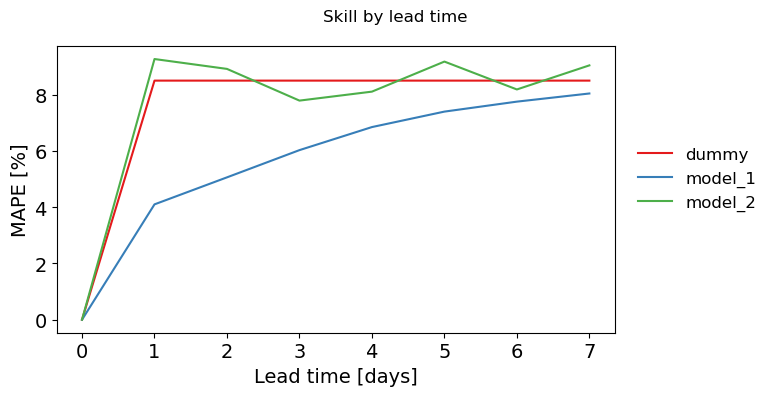

In [251]:
metric = "mape"

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.lineplot(
    data=skill_for_plot,
    x="lead_time",
    y=metric,
    hue="model",
    ax=ax,
)
fig.suptitle("Skill by lead time")

ax.set_xlabel("Lead time [days]", fontsize=14)
ax.set_ylabel("MAPE [%]", fontsize=14)
ax.legend(frameon=False, fontsize=12, bbox_to_anchor=(1.28, 0.7)),
ax.tick_params(axis="both", which="major", labelsize=14)

plt.tight_layout()
plt.show()

The previous plot only shows one value for each lead time; however, it can be interesting see evaluate how the errors are distributed. The following section shows how to plot how the distribution of error changes as the lead time grows.

### Distribution per lead time

The skilltable returns one value per category, e.g. (model_1, lead_time=2) and we would like to have a collection of points to draw the distribution. For this reason, we cannot generate the plot from the skill. Instead, we use the raw dataframe that contains all observations per model and lead_time.

In [252]:
df1 = pd.melt(matched_model_results.reset_index(), id_vars=["time", "lead_time", "observation"], var_name="model")

df1["error"] = df1["observation"] - df1["value"]
df1["absolute_error"] = abs(df1["error"])
df1["percentage_error"] = 100 * df1["absolute_error"] / df1["observation"]

ylabel_dict = {"error": "Error", "absolute_error": "Absolute error", "percentage_error": "Percentage error [%]"}
errorcol = "percentage_error"

models = df1["model"].unique().tolist()

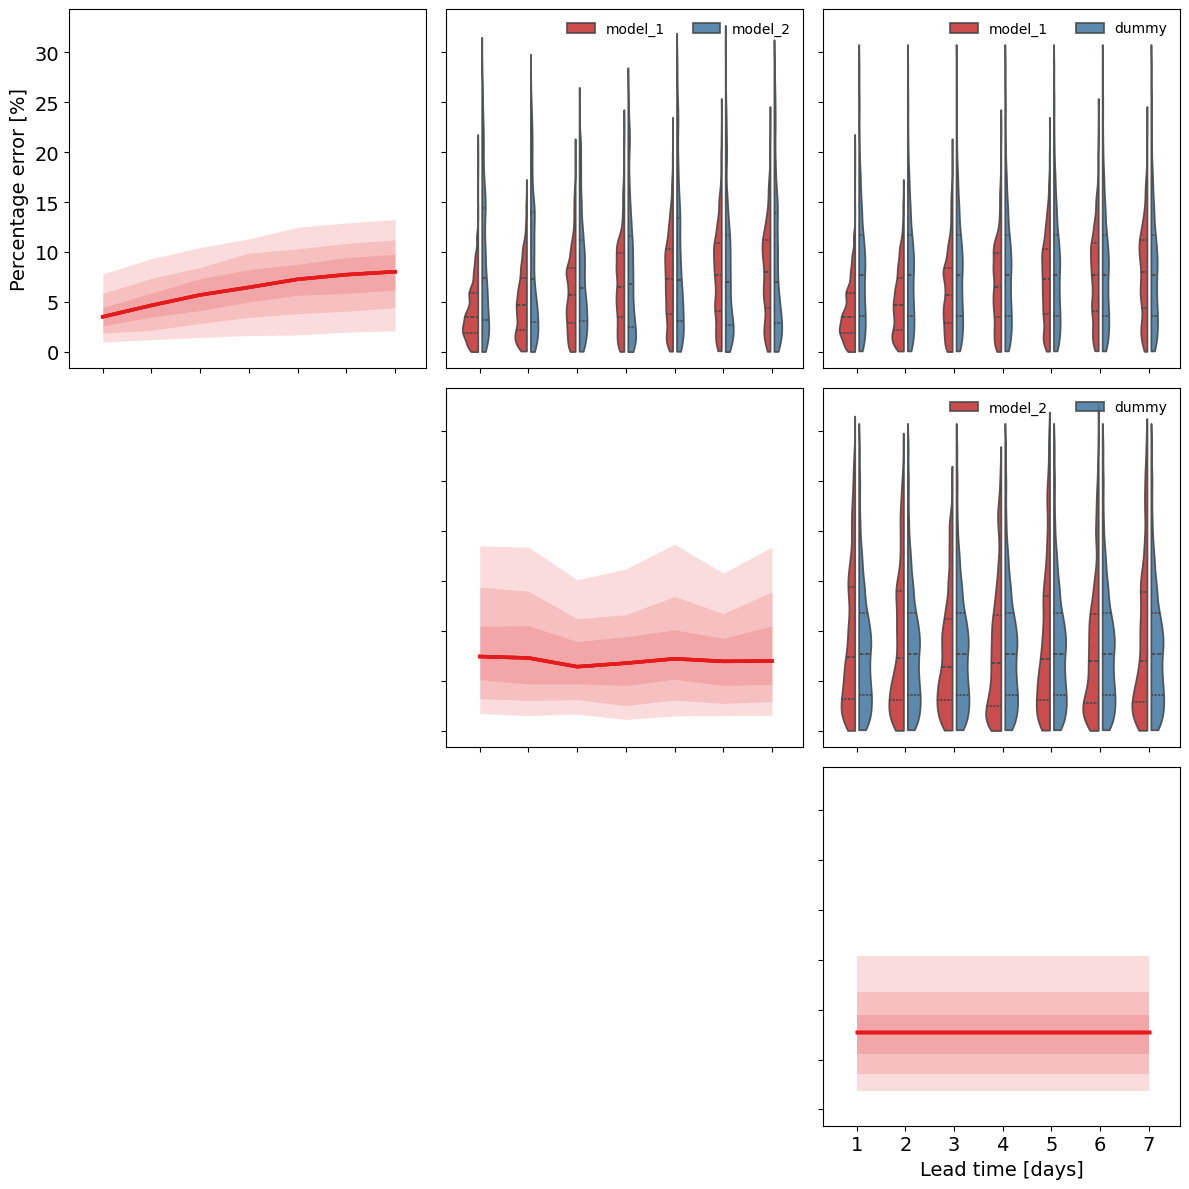

In [289]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

for i, model_i in enumerate(models):

    df_ii = df1.loc[df1["model"] == model_i, :].copy()
    df_ii["lead_time"] = df_ii["lead_time"] - 1  # This workaround was necessary for correctly matching the axes

    for interval in [25, 50, 75]:
        sns.lineplot(
            df_ii,
            x="lead_time",
            y="percentage_error",
            estimator="median",
            errorbar=("pi", interval),
            hue="model",
            ax=axes[i, i],
            linewidth=2.5,
            err_kws=dict(linewidth=0, alpha=0.15)
        )
    axes[i, i].legend([],[], frameon=False)
    axes[i, i].set_xlabel("Lead time [days]", fontsize=14)
    axes[i, i].set_ylabel(ylabel_dict[errorcol], fontsize=14)
    axes[i, i].tick_params(axis="both", which="major", labelsize=14)

    other_models = [m for m in models if m != model_i]
    for model_j in other_models:

        j = models.index(model_j)
        if j > i:
            comb = (model_i, model_j)
            sns.violinplot(
                data=df1.loc[df1["model"].isin(comb), :],
                x="lead_time",
                y=errorcol,
                hue="model",
                split=True,
                gap=0.2,
                inner="quarts",
                ax=axes[i, j],
                alpha=0.9,
                saturation=0.7,
                bw_adjust=0.6,
                common_norm=True,
                density_norm="area",
                cut=0,
                )
            axes[i, j].legend(frameon=False, ncols = 2)
        else:
            axes[i, j].set_axis_off()


plt.tight_layout()
plt.show()

### Appendix: Building a Skill object using `ComparerCollection`

In [6]:
# observations = pd.read_csv(path_to_file("observations.csv"), parse_dates=True)
# forecast_model_1 = pd.read_csv(path_to_file("forecast_model_1.csv"), parse_dates=True, index_col=0)
# forecast_model_2 = pd.read_csv(path_to_file("forecast_model_2.csv"), parse_dates=True, index_col=0)


# obs = ms.PointObservation(observations)
# ms.match(obs=obs, mod=ms.PointModelResult(results_model_1[1], name="model_1_1"))

# list_of_comparers_1 = [ms.match(obs=obs, mod=ms.PointModelResult(results_model_1[i], name=f"model_1.{i}")) for i in range(0, 7 + 1)]
# list_of_comparers_2 = [ms.match(obs=obs, mod=ms.PointModelResult(results_model_2[i], name=f"model_2.{i}")) for i in range(0, 7 + 1)]
# cc = ms.ComparerCollection(list_of_comparers_1 + list_of_comparers_2)

# skill_A = cc.skill().to_dataframe()

# def get_model_name(x, sep="."):
#     return x[0].split(sep)[0]

# def get_lead_time(x, sep="."):
#     return x[0].split(sep)[1]

# skill_A["model"] = skill_A.index.to_series().apply(get_model_name)
# skill_A["lead_time"] = skill_A.index.to_series().apply(get_lead_time)

# skill_A.reset_index(drop=True, inplace=True)
# index_tuples = list(skill_A[["model", "lead_time"]].itertuples(index=False, name=None))
# skill_A.index = pd.MultiIndex.from_tuples([model_j for model_j in index_tuples], names=['model', 'lead_time'])
# skill_A = skill_A.sort_index().drop(columns=["model", "lead_time"])